In [53]:
# %pip install giza-sdk
# %pip install hvplot "polars[numpy]" "polars[plot]" matplotlib

In [69]:
import pandas as pd

df_block_time = pd.read_csv("ethereum_blocknumber_datetime.csv")
df_block_time = df_block_time.rename(columns={"BLOCK_NUMBER": "block_number", "BLOCK_TIMESTAMP": "block_timestamp"})
df_block_time.set_index("block_number", inplace=True)
df_block_time["block_date"] = pd.to_datetime(df_block_time["block_timestamp"]).dt.date

In [79]:
df_block_time.head()

,block_timestamp,block_date
block_number,,
12376729,2021-05-05 21:42:11.000,2021-05-05
12377729,2021-05-06 01:21:24.000,2021-05-06
12378729,2021-05-06 04:50:36.000,2021-05-06
12379729,2021-05-06 08:44:49.000,2021-05-06
12380729,2021-05-06 12:27:21.000,2021-05-06


In [83]:
block_to_date = df_block_time.to_dict()["block_date"]

In [36]:
from giza.datasets import DatasetsLoader

In [37]:
loader = DatasetsLoader()
df = loader.load('lens-posts')

Dataset read from cache.
Loading dataset lens-posts from cache.


In [38]:
df[0]["contentURI"][0]

'ar://79ClTC1sHVS7EZuuolo37hEfewP065K_L548a6D-W6E'

In [84]:
liquidity_df = loader.load('uniswapv3-ethereum-usdc-weth-500-liquidity-snapshots').to_pandas()
ticks_df = loader.load('uniswapv3-ethereum-usdc-weth-500-current-ticks')
pools_info_df = loader.load('uniswapv3-ethereum-pools-info')

Dataset read from cache.
Loading dataset uniswapv3-ethereum-usdc-weth-500-liquidity-snapshots from cache.
Dataset read from cache.
Loading dataset uniswapv3-ethereum-usdc-weth-500-current-ticks from cache.
Dataset read from cache.
Loading dataset uniswapv3-ethereum-pools-info from cache.


In [85]:

print(liquidity_df.head())
print(ticks_df.head())
print(pools_info_df.head())

   block_number in_token out_token     price      amount  tick_id
0      17917729     USDC      WETH  0.000543  320.109895   201130
1      17917729     USDC      WETH  0.000543  668.116523   201120
2      17917729     USDC      WETH  0.000542  683.064427   201110
3      17917729     USDC      WETH  0.000542  894.834874   201100
4      17917729     USDC      WETH  0.000541  582.447540   201090
shape: (5, 2)
┌──────────────┬──────────────┐
│ current_tick ┆ block_number │
│ ---          ┆ ---          │
│ i64          ┆ i64          │
╞══════════════╪══════════════╡
│ 201040       ┆ 17774729     │
│ 192936       ┆ 13458729     │
│ 205565       ┆ 15114729     │
│ 192623       ┆ 13520729     │
│ 205426       ┆ 16306729     │
└──────────────┴──────────────┘
shape: (5, 11)
┌─────────────┬────────────┬─────────┬────────┬───┬────────────┬────────────┬──────────┬───────────┐
│ address     ┆ tick_spaci ┆ token0  ┆ token1 ┆ … ┆ token0_add ┆ token1_add ┆ chain    ┆ pool_type │
│ ---         ┆ ng   

In [87]:
liquidity_df["block_date"] = liquidity_df["block_number"].map(lambda x: block_to_date[x])

In [88]:
liquidity_df.head()

,block_number,in_token,out_token,price,amount,tick_id,block_date
0,17917729,USDC,WETH,0.000543,320.109895,201130,2023-08-15
1,17917729,USDC,WETH,0.000543,668.116523,201120,2023-08-15
2,17917729,USDC,WETH,0.000542,683.064427,201110,2023-08-15
3,17917729,USDC,WETH,0.000542,894.834874,201100,2023-08-15
4,17917729,USDC,WETH,0.000541,582.447540,201090,2023-08-15


In [91]:
liquidity_df.groupby("block_date").agg(
    min_tick=("tick_id", "min"),
    max_tick=("tick_id", "max")
).reset_index()

,block_date,min_tick,max_tick
0,2021-05-05,193880,195870
1,2021-05-06,193530,195890
2,2021-05-07,193630,195940
3,2021-05-08,192690,195590
4,2021-05-09,192430,194820
...,...,...,...
852,2023-09-04,201310,203370
853,2023-09-05,201330,203450
854,2023-09-06,201320,203390
855,2023-09-07,201240,203380


In [41]:
import polars as pl
df = liquidity_df[["block_number", "price"]].group_by(by="block_number").agg(pl.col("price").max()).sort(by="block_number")

block_number,price
i64,f64
12376729,3443.33391
12377729,3466.827193
12378729,3496.419333
12379729,3438.173039
12380729,3491.528015
12381729,3567.404827
12382729,3447.123472
12383729,3504.820396
12384729,3421.025935


<Axes: xlabel='block_number'>

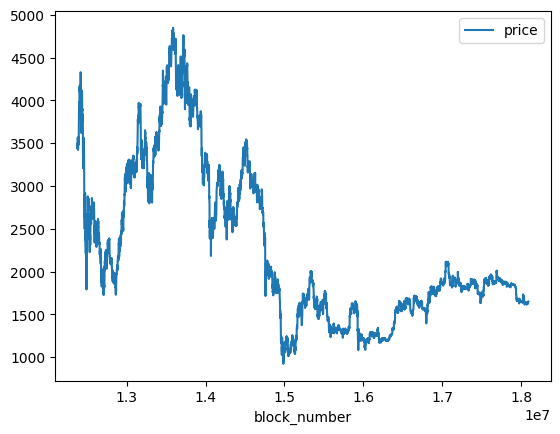

In [47]:
df.to_pandas().plot(x="block_number", y="price")

In [48]:
liquidity_df["block_number"].min(), liquidity_df["block_number"].max()

(12376729, 18089729)

In [49]:
liquidity_df.shape

(1149788, 6)